In [117]:
import pandas as pd
import numpy as np
import scipy 
from scipy.stats import norm


from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [118]:
filename='DataLab4.xlsx'
Migration_data = pd.read_excel('DataLab4.xlsx')

print(Migration_data)

  Rating  Prob_Loan_BBB  Loss_BBB  Prob_Loan_A  Loss_A
0    AAA         0.0002     -2.28       0.0009   -0.45
1     AA         0.0033     -2.10       0.0227   -0.23
2      A         0.0595     -1.57       0.9105   -0.12
3    BBB         0.8693     -0.46       0.0552    1.08
4     BB         0.0530      5.07       0.0074    3.16
5      B         0.0117      8.99       0.0026    5.56
6    CCC         0.0012     23.45       0.0001   18.78
7      D         0.0018     55.96       0.0006   55.96


In [119]:
#Q1

n_sims= 100000
n_times = n_sims * Migration_data['Prob_Loan_BBB']
answer1= pd.DataFrame({'Rating':Migration_data['Rating'],'Number of times': n_times})

print(answer1)

  Rating  Number of times
0    AAA             20.0
1     AA            330.0
2      A           5950.0
3    BBB          86930.0
4     BB           5300.0
5      B           1170.0
6    CCC            120.0
7      D            180.0


In [120]:
#Q2

alpha99 = 0.99
alpha999 = 0.999
alpha9999 = 0.9999
mu = 0
sigp = 3.35 


VaR99 = norm.ppf(alpha99,mu,1)*sigp
VaR999 = norm.ppf(alpha999,mu,1)*sigp
VaR9999 = norm.ppf(alpha9999,mu,1)*sigp

print(VaR99)
print(VaR999)
print(VaR9999)

7.793265378036817
10.352278225662175
12.458705226276624


In [121]:
#Q3a

np.random.seed(1) # Set random seed for reproducability
x1 = np.random.normal(0,1,size=(1,100000)) # 100,000 random numbers
x2 = np.random.normal(0,1,size=(1,100000))

In [122]:
#Q3b

probabilitiesBBB = Migration_data['Prob_Loan_BBB']
cumulativeprobBBB = np.cumsum(np.flip(probabilitiesBBB))
QuantilesBBB = norm.ppf(cumulativeprobBBB[:-1])

#We need to create the same vectors for the A rated one.
probabilitiesA = Migration_data['Prob_Loan_A']
cumulativeprobA = np.cumsum(np.flip(probabilitiesA))
QuantilesA = norm.ppf(cumulativeprobA[:-1])

print(QuantilesA)
print(QuantilesBBB)

[-3.2389 -3.1947 -2.7164 -2.3009 -1.507   1.9845  3.1214]
[-2.9112 -2.7478 -2.1781 -1.4931  1.5301  2.6968  3.5401]


In [131]:
#Q4

R = 0.35
q1 = x1
q2 = R*x1+np.sqrt(1-R**2)*x2 # Cholesky decomposition VL16 slides 13-15
#print(scipy.stats.pearsonr(q1, q2)) # Correlation and p-stat for null of correlation=0

In [124]:
#Q5
T=1
position=np.zeros((len(q1.T),1))

for i in range(len(q1.T)):
    q1temp= np.concatenate((QuantilesBBB, q1[:,i]))
    q1sorted=np.sort(q1temp)[::-1]
    bol_list=(q1sorted==q1[:,i])
    position[i,:] = [j for j, val in enumerate(bol_list) if val]
    
a = pd.DataFrame(position).value_counts().sort_index()

answer1['n_simulated'] = a.values
answer1['ratio']= answer1['Number of times']/a.values
print(answer1)

  Rating  Number of times  n_simulated     ratio
0    AAA             20.0           22  0.909091
1     AA            330.0          348  0.948276
2      A           5950.0         5996  0.992328
3    BBB          86930.0        87065  0.998449
4     BB           5300.0         5140  1.031128
5      B           1170.0         1124  1.040925
6    CCC            120.0          116  1.034483
7      D            180.0          189  0.952381


Text(0, 0.5, 'prob')

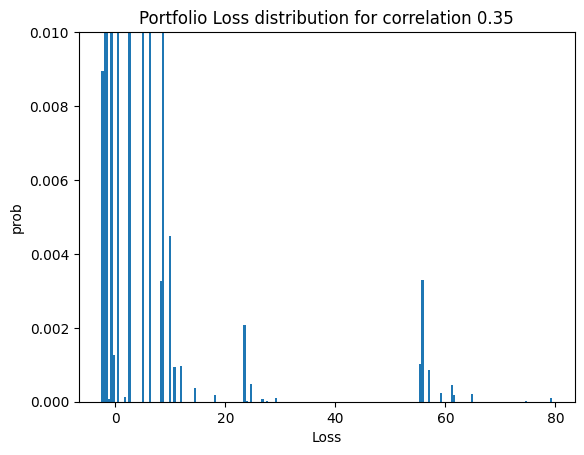

In [125]:
#Q6

loss_BBB = Migration_data["Loss_BBB"]
simulated_losses_BBB = np.zeros((len(q1.T),1))

for i in range(len(q1.T)):
    q1temp = np.concatenate((QuantilesBBB, q1[:,i]))
    q1sorted = np.sort(q1temp)[::-1] #sorts descending [::-1] reverses order
    bol_list = (q1sorted == q1[:,i])
    r = [j for j, val in enumerate(bol_list) if val]
    simulated_losses_BBB[i,:] = loss_BBB[r]
    
loss_A = Migration_data["Loss_A"]
simulated_losses_A = np.zeros((len(q2.T),1))


for i in range(len(q2.T)):
    q2temp = np.concatenate((QuantilesA, q2[:,i]))
    q2sorted = np.sort(q2temp)[::-1] #sorts descending [::-1] reverses order
    bol_list = (q2sorted == q2[:,i])
    r = [j for j, val in enumerate(bol_list) if val]
    simulated_losses_A[i,:] = loss_A[r]
    
Loss_Portfolio = simulated_losses_BBB + simulated_losses_A

plt.hist(Loss_Portfolio, density = True, bins = 200)
plt.ylim([0, 0.01])
plt.title('Portfolio Loss distribution for correlation '+ str(R))
plt.xlabel('Loss')
plt.ylabel('prob')

In [129]:
VaRs = np.quantile(Loss_Portfolio, [0.99,0.999,0.9999])
print(VaRs)

[ 8.87 55.84 64.95]


In [ ]:
#Q8 

#a)Well because the likelihood of default is really low but carries large losses.
#Because of the low probability these are not captured in the lower confidence levels. 
#More over we seem to have "fatter" tails in the "real" loss dist. 

#b) In finance it is usually good to add another security in your portfolio to increase the level of diversification.
#But when assets are correlated the loss that one experiences increases in probability compared to the case with low correlation.
#Since when one bond gets a downgrade, If we have a high R(degree of correlation), 
#it also means that the other bond will experience a downgrade, and this will have a higher loss compared to if the
#correlation was low.